# Example Layer Wise Relevance Propagation

In [ ]:
# ! pip install torch torchvision numpy pydantic umap-learn interpret faiss-cpu torchsummary matplotlib pandas seaborn scikit-learn scikit-image pytorch-lightning[extra] --no-cache-dir --ignore-installed

In [1]:
import os
import torch
import copy

import numpy as np
import torch.nn as nn
import torch.optim as optim

from pytorch_lightning import Trainer
from torchvision.transforms import functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from models.vgg import VGG
from data.brain_tumor_mri import BrainTumorMRI
from interpret.layer_wise_rp import LayerWiseRP
from viz.lwrp import plot_relevance, analyze_example

from sklearn.metrics.cluster import normalized_mutual_info_score

from torchmetrics import Accuracy

In [2]:
RND_SEED=31
torch.manual_seed(RND_SEED)
torch.cuda.manual_seed_all(RND_SEED)
np.random.seed(RND_SEED)

In [9]:
CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = torch.device("cpu:0")
BATCH_SIZE = 32
NUM_WORKERS = 8
EPOCHS = 30

In [10]:
DATASETS_PATH = './datasets/'
# DATASETS_PATH = '/root/xai-clustering/datasets/'
DATASET_RATIO = None
brain_tumor = BrainTumorMRI(DATASETS_PATH, train_size=0.7, val_size=0.3, random_state=555)

# MODEL

In [11]:
# model = VGG()

# PATH = "./checkpoints/best-cnn-checkpoint-v5.ckpt"
# model = VGG.load_from_checkpoint(PATH)

In [12]:
model = VGG()

from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    filename="vgg-{epoch}-{train_loss:.4f}-{train_acc:.4f}-{val_loss:.4f}-{val_acc:.4f}",
    save_top_k=3,
    verbose=False,
    save_last=True,
    monitor="val_loss",
    mode="min"
)

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=False)
logger = CSVLogger(save_dir="./", name="experiments", flush_logs_every_n_steps=1)

limit_kwargs = {}
if DATASET_RATIO is not None:
    limit_kwargs = {
        "limit_train_batches": DATASET_RATIO,
        "limit_val_batches": DATASET_RATIO,
        "limit_test_batches": DATASET_RATIO
    }
trainer = Trainer(
    max_epochs=EPOCHS,
    callbacks=[early_stopping_callback, checkpoint_callback],
    log_every_n_steps=1,
    logger=logger,
    **limit_kwargs
)

trainer.fit(
    model,
    train_dataloaders=brain_tumor.train_dataloader,
    val_dataloaders=brain_tumor.val_dataloader
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 14.7 M
1 | avgpool           | AdaptiveAvgPool2d  | 0     
2 | classifier        | Sequential         | 119 M 
3 | loss_fn           | CrossEntropyLoss   | 0     
4 | train_acc         | MulticlassAccuracy | 0     
5 | val_acc           | MulticlassAccuracy | 0     
6 | test_acc          | MulticlassAccuracy | 0     
---------------------------------------------------------
16.4 K    Trainable params
134 M     Non-trainable params
134 M     Total params
537.108   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training is started!


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Training is done.


In [ ]:
checkpoint_callback.best_model_path

In [14]:
trainer.logger.log_dir

'./experiments/version_1'

In [13]:
import pandas as pd
pd.set_option('display.max_rows', None)
metrics_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

In [15]:
metrics_df

(5430, 10)

In [ ]:
checkpoint_path = "./lightning_logs/version_14/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
print(checkpoint.keys())

In [ ]:
checkpoint['epoch']

In [ ]:
from pprint import pprint
pprint(checkpoint['callbacks'])

## TRAINING

# TESTING

In [ ]:
test_results = trainer.test(model, dataloaders=brain_tumor.test_dataloader)

In [ ]:
print(model.logger.experiment)

In [ ]:
test_results[0].get('test_loss')

In [17]:
batch_preds = trainer.predict(model, dataloaders=brain_tumor.test_dataloader)

Predicting: 0it [00:00, ?it/s]

In [23]:
import numpy as np

truth_labels = []
preds_labels = []
for truth, pred in batch_preds:
    truth_labels.append(truth)
    preds_labels.append(pred)
truth_labels = np.concatenate(truth_labels)
preds_labels = np.concatenate(preds_labels)

In [27]:
import pickle
with open("preds.dump", "wb") as f:
    pickle.dump([truth_labels, preds_labels], f)

# ANALYZING MODEL

# ANALYZING IMAGES

In [29]:
data, labels = next(iter(brain_tumor.test_dataloader))

Ground Truth for this image:  tensor(0)
Prediction was:  1


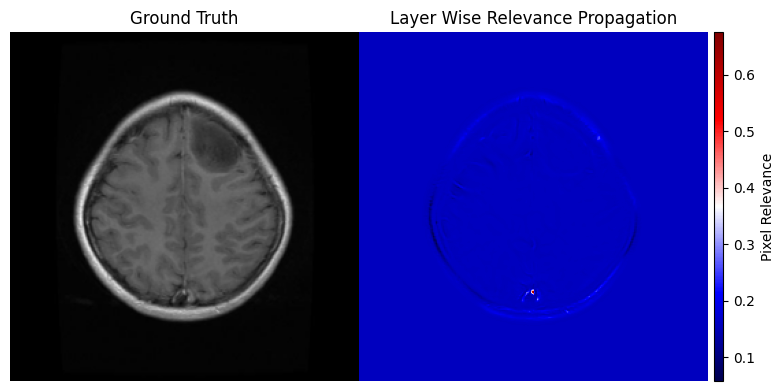

This image is not classified correctly.


In [32]:
lw = LayerWiseRP()

image_id = 5
image_1 = data[image_id]
image_lwrp = lw.apply(model, image_1, DEVICE)
image_1 = image_1.unsqueeze(0)
image_1_label = labels[image_id]
image_1_pred = model(image_1).max(1).indices.detach().cpu().numpy()
image_1 = image_1.squeeze(0)

analyze_example(
    image=F.to_pil_image(image_1),
    label=image_1_label,
    image_lwrp=image_lwrp[:,:,0],
    pred_label=image_1_pred[0]
)